# saving Maximum Reward model locally

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

In [2]:

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# Define simple grid world environment

In [3]:
class GridWorldEnv:
    def __init__(self, size=5):
        self.size = size
        self.reset()

    def reset(self):
        # Initialize agent position randomly
        self.agent_pos = [random.randint(0, self.size-1), random.randint(0, self.size-1)]
        # Set goal position randomly but ensure it's different from agent position
        self.goal_pos = self.agent_pos.copy()
        while self.goal_pos == self.agent_pos:
            self.goal_pos = [random.randint(0, self.size-1), random.randint(0, self.size-1)]
        return self._get_state()

    def step(self, action):
        # Actions: 0: up, 1: right, 2: down, 3: left
        if action == 0 and self.agent_pos[0] > 0:  # Up
            self.agent_pos[0] -= 1
        elif action == 1 and self.agent_pos[1] < self.size - 1:  # Right
            self.agent_pos[1] += 1
        elif action == 2 and self.agent_pos[0] < self.size - 1:  # Down
            self.agent_pos[0] += 1
        elif action == 3 and self.agent_pos[1] > 0:  # Left
            self.agent_pos[1] -= 1

        # Check if goal is reached
        done = (self.agent_pos == self.goal_pos)

        # Calculate reward: -0.1 per step, +1 for reaching goal
        reward = 1.0 if done else -0.1

        return self._get_state(), reward, done

    def _get_state(self):
        # State is represented as [agent_x, agent_y, goal_x, goal_y]
        return np.array([self.agent_pos[0], self.agent_pos[1],
                         self.goal_pos[0], self.goal_pos[1]])

    def render(self):
        grid = np.zeros((self.size, self.size), dtype=str)
        grid.fill('.')
        grid[self.agent_pos[0], self.agent_pos[1]] = 'A'
        grid[self.goal_pos[0], self.goal_pos[1]] = 'G'

        # If agent and goal are in the same position
        if self.agent_pos == self.goal_pos:
            grid[self.agent_pos[0], self.agent_pos[1]] = 'X'

        for row in grid:
            print(' '.join(row))

        print()


# Define the policy network


In [4]:
class PolicyNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(PolicyNetwork, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size),
            nn.Softmax(dim=-1)
        )

    def forward(self, x):
        return self.network(x)


In [5]:
# Define the value network
class ValueNetwork(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(ValueNetwork, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )

    def forward(self, x):
        return self.network(x)


In [6]:
# Function to generate trajectories
def generate_trajectories(env, policy_net, num_episodes=10, max_steps=100):
    trajectories = []

    for _ in range(num_episodes):
        states, actions, rewards, log_probs = [], [], [], []
        state = env.reset()
        done = False
        step_count = 0

        while not done and step_count < max_steps:
            state_tensor = torch.FloatTensor(state).to(device)
            action_probs = policy_net(state_tensor)

            # Sample action from the distribution
            action_distribution = torch.distributions.Categorical(action_probs)
            action = action_distribution.sample()
            log_prob = action_distribution.log_prob(action)

            next_state, reward, done = env.step(action.item())

            states.append(state)
            actions.append(action.item())
            rewards.append(reward)
            log_probs.append(log_prob.item())

            state = next_state
            step_count += 1

        # Calculate returns
        returns = []
        G = 0
        for r in reversed(rewards):
            G = r + 0.99 * G  # 0.99 is the discount factor
            returns.insert(0, G)

        trajectories.append({
            'states': np.array(states),
            'actions': np.array(actions),
            'rewards': np.array(rewards),
            'returns': np.array(returns),
            'log_probs': np.array(log_probs)
        })

    return trajectories

In [7]:
# Function to generate reference and candidate trajectories for preference learning
def generate_preference_pairs(env, policy_net, value_net, num_pairs=5, max_steps=100):
    reference_trajectories = generate_trajectories(env, policy_net, num_episodes=num_pairs, max_steps=max_steps)
    candidate_trajectories = generate_trajectories(env, policy_net, num_episodes=num_pairs, max_steps=max_steps)

    pairs = []
    for ref_traj, cand_traj in zip(reference_trajectories, candidate_trajectories):
        # Use total return as a proxy for preference
        ref_return = np.sum(ref_traj['rewards'])
        cand_return = np.sum(cand_traj['rewards'])

        # Determine which trajectory is preferred based on total return
        if ref_return > cand_return:
            preferred = ref_traj
            non_preferred = cand_traj
        else:
            preferred = cand_traj
            non_preferred = ref_traj

        pairs.append((preferred, non_preferred))

    return pairs


In [8]:
# Function to evaluate agent performance
def evaluate_agent(env, policy_net, num_episodes=5, max_steps=100):
    eval_returns = []
    for _ in range(num_episodes):
        state = env.reset()
        total_reward = 0
        done = False
        step_count = 0

        while not done and step_count < max_steps:
            state_tensor = torch.FloatTensor(state).to(device)
            action_probs = policy_net(state_tensor)
            action = torch.argmax(action_probs).item()

            next_state, reward, done = env.step(action)
            total_reward += reward
            state = next_state
            step_count += 1

        eval_returns.append(total_reward)

    return np.mean(eval_returns)


In [13]:

# GRPO training function with best model saving
def train_grpo(env, policy_net, value_net, optimizer_policy, optimizer_value,
               num_iterations=100, batch_size=4, max_steps=100, save_dir='./models'):

    # Create directory for saving models if it doesn't exist
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    returns_history = []
    loss_history = []
    best_return = float('-inf')
    best_model_path = os.path.join(save_dir, 'best_policy_model.pth')

    for iteration in tqdm(range(num_iterations)):
        # Generate preference pairs
        preference_pairs = generate_preference_pairs(env, policy_net, value_net,
                                                    num_pairs=batch_size, max_steps=max_steps)

        # Train on preference pairs
        policy_loss = 0
        value_loss = 0

        for preferred, non_preferred in preference_pairs:
            # Value loss
            preferred_states = torch.FloatTensor(preferred['states']).to(device)
            preferred_returns = torch.FloatTensor(preferred['returns']).unsqueeze(1).to(device)
            predicted_values = value_net(preferred_states)
            batch_value_loss = nn.MSELoss()(predicted_values, preferred_returns)
            value_loss += batch_value_loss

            # Policy loss - GRPO approach
            # Calculate advantage using the value network
            advantages = preferred_returns - predicted_values.detach()

            # Get log probabilities of actions taken
            preferred_actions = torch.LongTensor(preferred['actions']).to(device)
            action_probs = policy_net(preferred_states)
            dist = torch.distributions.Categorical(action_probs)
            log_probs = dist.log_prob(preferred_actions)

            # Calculate importance weights from old log probs
            old_log_probs = torch.FloatTensor(preferred['log_probs']).to(device)
            ratios = torch.exp(log_probs - old_log_probs)

            # Clipped PPO loss
            eps = 0.2  # PPO clipping parameter
            clipped_ratios = torch.clamp(ratios, 1-eps, 1+eps)
            batch_policy_loss = -torch.min(ratios * advantages, clipped_ratios * advantages).mean()
            policy_loss += batch_policy_loss

        # Average losses
        policy_loss /= len(preference_pairs)
        value_loss /= len(preference_pairs)

        # Update policy network
        optimizer_policy.zero_grad()
        policy_loss.backward()
        optimizer_policy.step()

        # Update value network
        optimizer_value.zero_grad()
        value_loss.backward()
        optimizer_value.step()

        # Evaluate performance every 10 iterations
        if iteration % 100 == 0:
            avg_return = evaluate_agent(env, policy_net, num_episodes=5, max_steps=max_steps)
            returns_history.append(avg_return)
            loss_history.append((policy_loss.item(), value_loss.item()))

            print(f"Iteration {iteration}, Avg Return: {avg_return:.2f}, " +
                  f"Policy Loss: {policy_loss.item():.4f}, Value Loss: {value_loss.item():.4f}")

            # Save the best model based on average return
            if avg_return > best_return:
                best_return = avg_return
                torch.save({
                    'policy_state_dict': policy_net.state_dict(),
                    'value_state_dict': value_net.state_dict(),
                    'iteration': iteration,
                    'return': avg_return
                }, best_model_path)
                print(f"New best model saved with average return: {avg_return:.2f}")

    print(f"Training complete. Best model achieved average return: {best_return:.2f}")
    return returns_history, loss_history, best_model_path


In [14]:
env = GridWorldEnv(size=5)

# State size: agent_x, agent_y, goal_x, goal_y
state_size = 4
hidden_size = 64
action_size = 4  # up, right, down, left

policy_net = PolicyNetwork(state_size, hidden_size, action_size).to(device)
value_net = ValueNetwork(state_size, hidden_size).to(device)

optimizer_policy = optim.Adam(policy_net.parameters(), lr=0.001)
optimizer_value = optim.Adam(value_net.parameters(), lr=0.001)


In [15]:

# Train the agent
print("Starting GRPO training...")
returns_history, loss_history, best_model_path = train_grpo(
    env, policy_net, value_net, optimizer_policy, optimizer_value,
    num_iterations=1000, batch_size=4, max_steps=20, save_dir='./grpo_models'
)


Starting GRPO training...


  0%|          | 1/1000 [00:00<02:55,  5.70it/s]

Iteration 0, Avg Return: -2.00, Policy Loss: 0.1185, Value Loss: 0.9976
New best model saved with average return: -2.00


 10%|█         | 102/1000 [00:15<01:51,  8.03it/s]

Iteration 100, Avg Return: -1.40, Policy Loss: -0.3027, Value Loss: 0.2501
New best model saved with average return: -1.40


 20%|██        | 203/1000 [00:26<01:13, 10.82it/s]

Iteration 200, Avg Return: -0.94, Policy Loss: -0.2112, Value Loss: 0.0676
New best model saved with average return: -0.94


 30%|███       | 303/1000 [00:34<00:46, 15.06it/s]

Iteration 300, Avg Return: -0.36, Policy Loss: 0.0411, Value Loss: 0.0655
New best model saved with average return: -0.36


 40%|████      | 404/1000 [00:41<00:33, 17.99it/s]

Iteration 400, Avg Return: 0.76, Policy Loss: 0.1076, Value Loss: 0.0447
New best model saved with average return: 0.76


 50%|█████     | 505/1000 [00:47<00:24, 19.89it/s]

Iteration 500, Avg Return: 0.86, Policy Loss: -0.0218, Value Loss: 0.0061
New best model saved with average return: 0.86


 60%|██████    | 605/1000 [00:52<00:18, 21.32it/s]

Iteration 600, Avg Return: 0.74, Policy Loss: 0.0188, Value Loss: 0.0058


 70%|███████   | 704/1000 [00:57<00:16, 17.67it/s]

Iteration 700, Avg Return: 0.74, Policy Loss: 0.0233, Value Loss: 0.0026


 80%|████████  | 805/1000 [01:01<00:08, 23.00it/s]

Iteration 800, Avg Return: 0.78, Policy Loss: -0.0425, Value Loss: 0.0092


 90%|█████████ | 904/1000 [01:06<00:04, 23.59it/s]

Iteration 900, Avg Return: 0.76, Policy Loss: 0.0045, Value Loss: 0.0012


100%|██████████| 1000/1000 [01:10<00:00, 14.12it/s]


Training complete. Best model achieved average return: 0.86


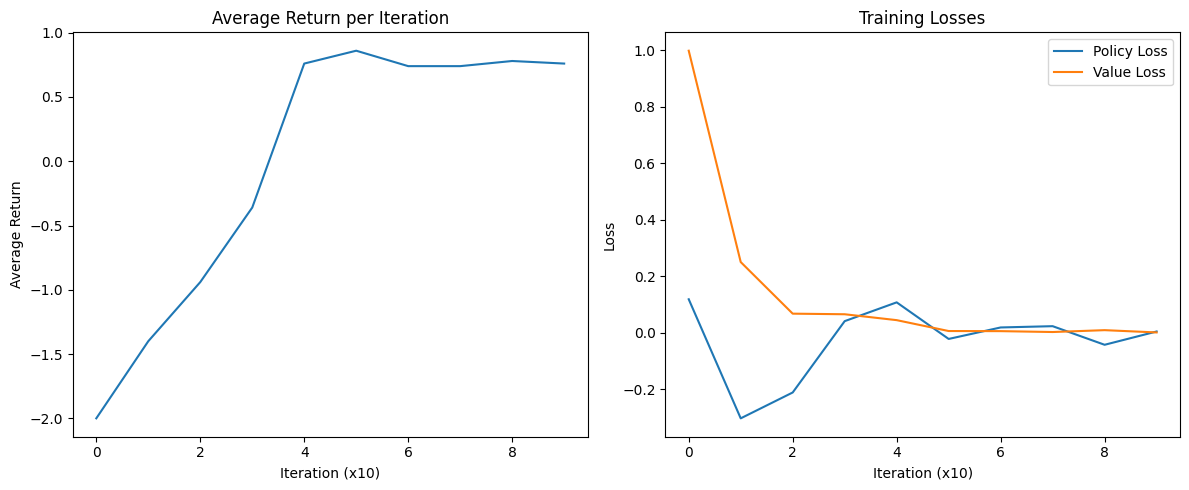

In [16]:

# Plot training results
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(returns_history)
plt.title('Average Return per Iteration')
plt.xlabel('Iteration (x10)')
plt.ylabel('Average Return')

plt.subplot(1, 2, 2)
policy_losses = [x[0] for x in loss_history]
value_losses = [x[1] for x in loss_history]
plt.plot(policy_losses, label='Policy Loss')
plt.plot(value_losses, label='Value Loss')
plt.title('Training Losses')
plt.xlabel('Iteration (x10)')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()



In [18]:
# Load the best model
print(f"\nLoading best model from {best_model_path}")
try:
    # First try loading with weights_only=True (default in PyTorch 2.6+)
    checkpoint = torch.load(best_model_path)
except Exception as e:
    print(f"First loading attempt failed, trying with weights_only=False: {str(e)}")
    # Try again with weights_only=False
    checkpoint = torch.load(best_model_path, weights_only=False)

policy_net.load_state_dict(checkpoint['policy_state_dict'])
value_net.load_state_dict(checkpoint['value_state_dict'])
print(f"Loaded best model from iteration {checkpoint['iteration']} with average return: {checkpoint['return']:.2f}")


Loading best model from ./grpo_models/best_policy_model.pth
First loading attempt failed, trying with weights_only=False: Weights only load failed. This file can still be loaded, to do so you have two options, do those steps only if you trust the source of the checkpoint. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL numpy._core.multiarray.scalar was not an allowed global by default. Please use `torch.serialization.add_safe_globals([scalar])` or the `torch.serialization.safe_globals([scalar])` context manager to allowlist this global if you trust this class/functi

In [36]:

# Demonstrate best trained agent untill it achieves max set reward(0.9)
while total_reward <=0.9:
  print("\nDemonstrating best trained agent:")
  state = env.reset()
  env.render()

  done = False
  step_count = 0
  total_reward = 0

  while not done and step_count < 20:
      state_tensor = torch.FloatTensor(state).to(device)
      action_probs = policy_net(state_tensor)
      action = torch.argmax(action_probs).item()

      action_names = ["UP", "RIGHT", "DOWN", "LEFT"]
      print(f"Step {step_count+1}: Agent chooses {action_names[action]}")

      next_state, reward, done = env.step(action)
      total_reward += reward
      state = next_state
      env.render()
      step_count += 1

  print(f"Episode finished with total reward: {total_reward:.2f}")
  if done:
      print("Goal reached!")
  else:
      print("Maximum steps reached before finding goal.")



Demonstrating best trained agent:
G . . . .
. A . . .
. . . . .
. . . . .
. . . . .

Step 1: Agent chooses UP
G A . . .
. . . . .
. . . . .
. . . . .
. . . . .

Step 2: Agent chooses LEFT
X . . . .
. . . . .
. . . . .
. . . . .
. . . . .

Episode finished with total reward: 0.90
Goal reached!

Demonstrating best trained agent:
. . . . .
. G . . .
. . . . .
. . . . .
. . A . .

Step 1: Agent chooses UP
. . . . .
. G . . .
. . . . .
. . A . .
. . . . .

Step 2: Agent chooses UP
. . . . .
. G . . .
. . A . .
. . . . .
. . . . .

Step 3: Agent chooses LEFT
. . . . .
. G . . .
. A . . .
. . . . .
. . . . .

Step 4: Agent chooses UP
. . . . .
. X . . .
. . . . .
. . . . .
. . . . .

Episode finished with total reward: 0.70
Goal reached!

Demonstrating best trained agent:
. . . . .
. . . . .
A . G . .
. . . . .
. . . . .

Step 1: Agent chooses RIGHT
. . . . .
. . . . .
. A G . .
. . . . .
. . . . .

Step 2: Agent chooses RIGHT
. . . . .
. . . . .
. . X . .
. . . . .
. . . . .

Episode finish